<a href="https://colab.research.google.com/github/akiFQC/colaboratry_DNN_API_collection/blob/master/adversarial_example_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flask web application of adversarial examples  VGG19

In [1]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-08-04 09:44:52--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.22.145.207, 52.203.102.189, 52.73.9.93, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.22.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13607069 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  12.98M  39.7MB/s    in 0.3s    

2019-08-04 09:44:53 (39.7 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13607069/13607069]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
from flask import Flask, render_template, send_from_directory, request, redirect, url_for

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import Variable
from chainer.backends import cuda

import numpy as np
import pandas as pd
import cupy as cp

import os, sys
import pprint
import time
import urllib.error
import urllib.request
from PIL import Image
import io
import random, string
from matplotlib import pyplot as plt



In [0]:
def download_file(url, dst_path):
    try:
        with urllib.request.urlopen(url) as web_file:
            data = web_file.read()
            with open(dst_path, mode='wb') as local_file:
                local_file.write(data)
    except urllib.error.URLError as e:
        print(e)

In [0]:
# カテゴリーのリストを取得
download_file( "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt", "category.txt")

category={}

def extract_line(line):
    line =line.replace("{", "")
    line=line.replace("\}", "")
    line=line.replace("\'", "")
    line=line.replace("\n", "")
    idx, name = line.split(":")
    return idx, name[:-1]

with open("category.txt", "r") as f :
    lili= f.readlines() 


for li in lili:
    idx, name = extract_line(li)
    category[int(idx)]=name
    
    
def reverse_img(image):
    image = image.transpose((1, 2, 0))
   
    image = image + np.array([103.939, 116.779, 123.68], dtype="float32")
    image =np.clip(image, 0, 255)
    return image[:, :, [2, 1, 0]].astype("int")

In [0]:
def randomname(n):
    randlst = [random.choice(string.ascii_letters + string.digits) for i in range(n)]
    return ''.join(randlst)

In [0]:
html = """

<!DOCTYPE html>
<html>
<head>
<meta charset="utf-8" />
<title>Adversarial Examples with VGG19</title>
</head>
<body>
<h1>Adversarial Examples</h1>
<form action="/post" method="post" enctype="multipart/form-data">
    <p><input type="file" name="uploadFile"/></p>
    <p><input type="submit" value="send"/></p>
</form>

{% if ulr_adv_Image %}

    <p>Original Image</p>
    <p><img src="{{ ulr_original_Image }}"></p>
    <p>{{ original_class }}</p>
    <p>Adversarial Image</p>
    <p><img src="{{ ulr_adv_Image }}"></p>
    <p>{{ adv_class }}</p>

{% endif %}

</body>
</html>

"""

In [0]:
#Saving html file
if not os.path.isdir( "templates" ):
    os.makedirs( "templates" )
with open("templates/index.html", mode='w') as f:
    f.write(html)
    
#Making tmp folder to use temporarily stored
if not os.path.isdir( "tmp" ):
    os.makedirs( "tmp" )

In [8]:
model =  L.VGG19Layers()
model.to_gpu(0)

Now loading caffemodel (usually it may take few minutes)


tmp/Gro%C3%9Fer_Schweizer_Sennenhund.jpg


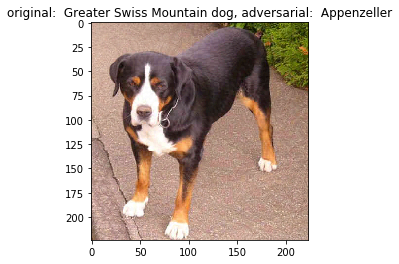

In [9]:
# テスト用
url = "https://upload.wikimedia.org/wikipedia/commons/5/5c/Gro%C3%9Fer_Schweizer_Sennenhund.jpg"

data_path =  "tmp/" + url.split("/")[-1]
print(data_path)
download_file( url, data_path)

# メインとなる処理
def adversarial_example_from_path(path, model, num_iter=3, ord_norm = cp.inf, epsilon=3,  lr = 1):
    if ord_norm == float("inf") or ord_norm is np.inf:
        ord_norm = cp.inf
    img = Image.open(path)
    X_img =  L.model.vision.vgg.prepare(img)

    X_img = X_img[np.newaxis]

    x_cp = cp.asarray(X_img)
    x_cp = cuda.to_gpu(x_cp)
    x_pertu =  Variable(cp.zeros(x_cp.shape, dtype="float32"))
   
    for ii in range(num_iter):
        # loss
        loss =   F.softmax_cross_entropy(model(x_cp+x_pertu)["prob"], 
                                     F.argmax(F.softmax(model(x_cp)["prob"] ,axis=1),axis=1)
                                    )
        loss.backward()
        grad = x_pertu.grad 
        
        grad_1d = grad.reshape(-1)
        grad_1d  /= cp.linalg.norm(grad_1d, ord=ord_norm)
        grad = grad_1d.reshape(x_cp.shape)
        x_pertu.data += lr * cp.sign(grad)
        # clip
        norm_pertu = cp.linalg.norm(x_pertu.data.reshape(-1), ord=ord_norm)
        if norm_pertu > epsilon:
            x_pertu.data /= norm_pertu
       
    img_out = x_cp.copy() + x_pertu.data
    adv_img = reverse_img(cp.asnumpy(img_out[0]))
    
    label_adv = category[int(F.argmax(F.softmax(model(img_out)['prob'], axis=1), axis=1).data)]
    label_ori = category[int(F.argmax(F.softmax(model(x_cp)['prob'], axis=1), axis=1).data)]
    return adv_img, label_ori , label_adv 
    

    
# テスト
ad_img, label_ori, label_adv = adversarial_example_from_path(data_path, model)
plt.imshow(ad_img)
title = "original: "+label_ori+", adversarial: " +  label_adv
plt.title(title)
plt.show()

    

In [0]:
app = Flask(__name__)

@app.route("/")
def index():
    return render_template( "index.html" )

@app.route('/post', methods=['POST'])
def post():
    try:
        uploadFile = request.files['uploadFile']
    except:
        return redirect(url_for('index'))
    
    file_name_ori= randomname(24) + ".jpg"
    
    url_original_image = "tmp/" + file_name_ori
    url_adv_image = "tmp/" + file_name_ori.split(".")[0] +"_adversarialexample.jpg"
    uploadFile.save("tmp/" + file_name_ori)
    
    
    ad_img, label_ori, label_adv = adversarial_example_from_path(url_original_image, model=model)
    pilImg = Image.fromarray(np.uint8(ad_img))
    pilImg.save(url_adv_image)
    
    print('image size:', ad_img.shape, ", adversarial label:", label_adv, "original label:", label_ori)
    
    original_class = "label: " + label_ori
    adv_class = "label: " + label_adv
    

    return render_template( "index.html",
                                        ulr_original_Image = url_original_image,
                                        ulr_adv_Image = url_adv_image,
                                        original_class = original_class,
                                        adv_class = adv_class)
    
@app.route('/tmp/<filename>')
def uploaded_file(filename):
    return send_from_directory("./tmp", filename)
    


In [11]:
!cd ~
! ls
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


if __name__ == '__main__':
    app.run(port=6006)

category.txt  ngrok  ngrok-stable-linux-amd64.zip  sample_data	templates  tmp
https://75346b1b.ngrok.io
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:6006/ (Press CTRL+C to quit)
